# UTILIZING EXTERNAL DATA FOR ENHANCING BUILDING ENERGY DEMAND ESTIMATION
## Part 1: Data Preprocessing
### Prepared by: Said Bolluk

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

Use **Fivethirtyeight** style for figures:

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv("2020_Building_Energy_Benchmarking.csv")

In [4]:
data.head()

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,ThirdLargestPropertyUseTypeGFA,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,2020,MAYFLOWER PARK HOTEL,NonResidential,0659000030,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,...,NaN,801392,1457837,6326,Compliant,No Issue,2734351.0,632586.0,169.1,1.9
1,2,2020,PARAMOUNT HOTEL,NonResidential,0659000220,724 PINE ST,SEATTLE,WA,98101.0,47.61317,...,4622.0,568667,0,16614,Compliant,No Issue,1940292.0,1661402.0,98.6,1.1
2,3,2020,WESTIN HOTEL (Parent Building),NonResidential,0659000475,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,...,0.0,7478716,10359896,8955,Compliant,No Issue,25517379.0,895500.0,1043.2,1.4
3,5,2020,HOTEL MAX,NonResidential,0659000640,620 STEWART ST,SEATTLE,WA,98101.0,47.61412,...,NaN,345231,917724,8871,Compliant,No Issue,1177927.0,887059.0,129.6,2.1
4,8,2020,WARWICK SEATTLE HOTEL,NonResidential,0659000970,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,...,0.0,1102452,0,46034,Compliant,No Issue,3761566.0,4603411.0,264.5,2.3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628 entries, 0 to 3627
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3628 non-null   int64  
 1   DataYear                         3628 non-null   int64  
 2   BuildingName                     3628 non-null   object 
 3   BuildingType                     3628 non-null   object 
 4   TaxParcelIdentificationNumber    3628 non-null   object 
 5   Address                          3628 non-null   object 
 6   City                             3627 non-null   object 
 7   State                            3627 non-null   object 
 8   ZipCode                          3573 non-null   float64
 9   Latitude                         3626 non-null   float64
 10  Longitude                        3626 non-null   float64
 11  Neighborhood                     3626 non-null   object 
 12  CouncilDistrictCode 

Create a target column called **Total EUI (kbtu/sf)**, which is the summation of the end uses over the total building area: (Electricity + Steam Use + Natural) / PropertyGFABuilding(s). The unit is kBtu/sf.

In [6]:
for i in range(data.shape[0]):
    
    data.loc[i, "Electricity (kbtu)"] = data.loc[i, "Electricity(kWh)"] * 3.4121416
    data.loc[i, "NaturalGas (kbtu)"] = data.loc[i, "NaturalGas(therms)"] * 99.976129
    
    data.loc[i, "Total Consumption (kbtu)"] = data.loc[i, "Electricity (kbtu)"] + data.loc[i, "NaturalGas (kbtu)"] + data.loc[i, "SteamUse(kBtu)"]
    data.loc[i, "Total EUI (kbtu/sf)"] = data.loc[i, "Total Consumption (kbtu)"] / data.loc[i, "PropertyGFABuilding(s)"]

We need to observe the residential buildings with only one building for simplicity.

In [7]:
experimental_index = data.index[((data["BuildingType"]=="Multifamily LR (1-4)") | (data["BuildingType"]=="Multifamily MR (5-9)") | (data["BuildingType"]=="Multifamily HR (10+)")) & (data["NumberofBuildings"]==1)].tolist()

data = data.loc[experimental_index]
data = data.reset_index()
data = data.drop(columns="index")
data = data.drop(columns="EPAPropertyType")
data = data.drop(columns="NumberofBuildings")

Reduce the dataset only using the necessary columns.

In [8]:
features = [
    "BuildingType", "Neighborhood", "CouncilDistrictCode","Latitude", "Longitude", 
    "YearBuilt", "NumberofFloors", "PropertyGFABuilding(s)", "Electricity (kbtu)", 
    "NaturalGas (kbtu)", "Total Consumption (kbtu)", "Total EUI (kbtu/sf)",
]

reduced_data = data[features]

In [9]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BuildingType              1854 non-null   object 
 1   Neighborhood              1853 non-null   object 
 2   CouncilDistrictCode       1845 non-null   float64
 3   Latitude                  1853 non-null   float64
 4   Longitude                 1853 non-null   float64
 5   YearBuilt                 1854 non-null   int64  
 6   NumberofFloors            1854 non-null   int64  
 7   PropertyGFABuilding(s)    1854 non-null   int64  
 8   Electricity (kbtu)        1854 non-null   float64
 9   NaturalGas (kbtu)         1854 non-null   float64
 10  Total Consumption (kbtu)  1854 non-null   float64
 11  Total EUI (kbtu/sf)       1854 non-null   float64
dtypes: float64(7), int64(3), object(2)
memory usage: 173.9+ KB


In [10]:
print("Data:", data.shape)
print("Reduced Data:", reduced_data.shape)

Data: (1854, 44)
Reduced Data: (1854, 12)


Save a copy of the reduced_data: **seattle**

In [11]:
seattle = reduced_data.copy()

In [12]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(seattle)
categorical_columns = categorical_columns_selector(seattle)

In [13]:
print("Numerical features:", numerical_columns)
print("\nCategorical features:", categorical_columns)

Numerical features: ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFABuilding(s)', 'Electricity (kbtu)', 'NaturalGas (kbtu)', 'Total Consumption (kbtu)', 'Total EUI (kbtu/sf)']

Categorical features: ['BuildingType', 'Neighborhood']


# Data Preprocessing

In [14]:
seattle.isnull().sum()

BuildingType                0
Neighborhood                1
CouncilDistrictCode         9
Latitude                    1
Longitude                   1
YearBuilt                   0
NumberofFloors              0
PropertyGFABuilding(s)      0
Electricity (kbtu)          0
NaturalGas (kbtu)           0
Total Consumption (kbtu)    0
Total EUI (kbtu/sf)         0
dtype: int64

In [15]:
# Drow empty rows
seattle = seattle.dropna(subset=["Neighborhood"])

# Drop the rows with zero EUI or more than 2e8 EUI
drop_rows1 = seattle.index[seattle["Total Consumption (kbtu)"]==0].tolist()
drop_rows2 = seattle.index[seattle["Total Consumption (kbtu)"]>=2e8].tolist()
seattle = seattle.drop(drop_rows1)
seattle = seattle.drop(drop_rows2)

In [16]:
seattle.isnull().sum()

BuildingType                0
Neighborhood                0
CouncilDistrictCode         8
Latitude                    0
Longitude                   0
YearBuilt                   0
NumberofFloors              0
PropertyGFABuilding(s)      0
Electricity (kbtu)          0
NaturalGas (kbtu)           0
Total Consumption (kbtu)    0
Total EUI (kbtu/sf)         0
dtype: int64

In [17]:
seattle = seattle.reset_index()
seattle = seattle.drop(columns="index")

Fill in the empyty cells for the **Council District Code** according to the neighborhoods. The neighborhood info for the council district code is obtanined from this link: https://www.seattle.gov/neighborhoods/about-seattle/neighborhoods-and-council-districts

In [18]:
district_index = seattle.index[seattle["CouncilDistrictCode"].isna()].tolist()
seattle.loc[district_index]

,BuildingType,Neighborhood,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFABuilding(s),Electricity (kbtu),NaturalGas (kbtu),Total Consumption (kbtu),Total EUI (kbtu/sf)
1699,Multifamily MR (5-9),NORTHEAST,NaN,47.65660,-122.31783,1970,7,211754,3.951683e+06,0.000000e+00,3.951683e+06,18.661669
1701,Multifamily LR (1-4),DELRIDGE NEIGHBORHOODS,NaN,47.52142,-122.35916,2017,4,37434,1.299207e+06,0.000000e+00,1.299207e+06,34.706605
1705,Multifamily MR (5-9),CENTRAL,NaN,47.61967,-122.30183,2017,5,33889,4.461341e+05,7.577191e+05,1.203853e+06,35.523420
1707,Multifamily MR (5-9),DOWNTOWN,NaN,47.61860,-122.35480,2016,6,32489,7.159458e+05,4.970813e+05,1.213027e+06,37.336548
1720,Multifamily MR (5-9),SOUTHWEST,NaN,47.56204,-122.38813,2017,6,23090,5.825822e+05,4.399949e+05,1.022577e+06,44.286582
1721,Multifamily LR (1-4),NORTHEAST,NaN,47.66216,-122.30837,2016,4,17153,4.724724e+05,1.239704e+04,4.848695e+05,28.267327
1722,Multifamily LR (1-4),BALLARD,NaN,47.69591,-122.37353,2015,4,114259,2.124631e+06,1.682498e+06,3.807130e+06,33.320173
1727,Multifamily MR (5-9),EAST,NaN,47.62257,-122.32403,2017,7,32667,7.705059e+05,3.101260e+05,1.080632e+06,33.080230


In [19]:
missing_council = seattle.index[seattle["CouncilDistrictCode"].isna()].tolist()
new_distric_codes = np.array([4, 1, 3, 7, 1, 4, 6, 3])

for i in range(8):
    
    council_index, new_value = missing_council[i], new_distric_codes[i]
    seattle.loc[council_index, "CouncilDistrictCode"] = new_value

In [20]:
seattle.isnull().sum()

BuildingType                0
Neighborhood                0
CouncilDistrictCode         0
Latitude                    0
Longitude                   0
YearBuilt                   0
NumberofFloors              0
PropertyGFABuilding(s)      0
Electricity (kbtu)          0
NaturalGas (kbtu)           0
Total Consumption (kbtu)    0
Total EUI (kbtu/sf)         0
dtype: int64

Try to plot the scatter with colors according to the council district of each point

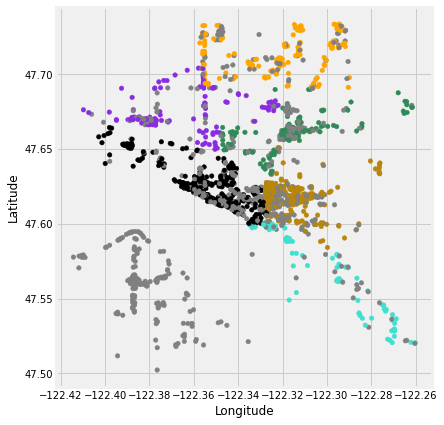

In [21]:
colors = ["grey", "turquoise", "darkgoldenrod", "seagreen", "orange", "blueviolet", "black"]
color_list = [colors[int(i-1)] for i in seattle.loc[:, "CouncilDistrictCode"]]

ax = seattle.plot.scatter(x="Longitude", y="Latitude", c=color_list, figsize=(6,7))
plt.show()

From the above scatter plot, we see that there are many points with wrong council district code.

Generalize the neighborhoods

In [22]:
north = seattle.index[seattle["Neighborhood"]=="SHARED: NORTH &amp; NORTHWEST"].tolist()
for i in north:
    seattle.loc[i, "Neighborhood"] = "NORTH"
    
central = seattle.index[seattle["Neighborhood"]=="SHARED: CENTRAL &amp; EAST"].tolist()
for i in central:
    seattle.loc[i, "Neighborhood"] = "CENTRAL"
    
delridge = seattle.index[seattle["Neighborhood"]=="SHARED: GREATER DUWAMISH &amp; DELRIDGE NEIGHBORHOODS"].tolist()
for i in delridge:
    seattle.loc[i, "Neighborhood"] = "DELRIDGE NEIGHBORHOODS"
    
ballard = seattle.index[seattle["Neighborhood"]=="SHARED: BALLARD &amp; LAKE UNION"].tolist()
for i in ballard:
    seattle.loc[i, "Neighborhood"] = "BALLARD"
    
north_west = seattle.index[seattle["Neighborhood"]=="SHARED: LAKE UNION &amp; NORTHWEST"].tolist()
for i in north_west:
    seattle.loc[i, "Neighborhood"] = "NORTHWEST"
    
north_west = seattle.index[seattle["Neighborhood"]=="SHARED: LAKE UNION &amp; NORTHWEST"].tolist() + seattle.index[seattle["Neighborhood"]=="SHARED: BALLARD &amp; NORTHWEST"].tolist()
for i in north_west:
    seattle.loc[i, "Neighborhood"] = "NORTHWEST"
    
lake = seattle.index[seattle["Neighborhood"]=="water"].tolist()
for i in lake:
    seattle.loc[i, "Neighborhood"] = "LAKE UNION"

Try to fix the council district codes according to the neihborhood info:

In [23]:
seven = seattle.index[seattle["Neighborhood"]=="DOWNTOWN"].tolist() + seattle.index[seattle["Neighborhood"]=="MAGNOLIA / QUEEN ANNE"].tolist()
for i in seven:
    seattle.loc[i, "CouncilDistrictCode"] = 7
    
six = seattle.index[seattle["Neighborhood"]=="BALLARD"].tolist() + seattle.index[seattle["Neighborhood"]=="NORTHWEST"].tolist()
for i in six:
    seattle.loc[i, "CouncilDistrictCode"] = 6
    
five = seattle.index[seattle["Neighborhood"]=="NORTH"].tolist()
for i in five:
    seattle.loc[i, "CouncilDistrictCode"] = 5
    
four = seattle.index[seattle["Neighborhood"]=="NORTHEAST"].tolist()
for i in four:
    seattle.loc[i, "CouncilDistrictCode"] = 4
    
three = seattle.index[seattle["Neighborhood"]=="CENTRAL"].tolist() + seattle.index[seattle["Neighborhood"]=="EAST"].tolist() + seattle.index[seattle["Neighborhood"]=="LAKE UNION"].tolist()
for i in three:
    seattle.loc[i, "CouncilDistrictCode"] = 3
    
two = seattle.index[seattle["Neighborhood"]=="GREATER DUWAMISH"].tolist() + seattle.index[seattle["Neighborhood"]=="SOUTHEAST"].tolist()
for i in two:
    seattle.loc[i, "CouncilDistrictCode"] = 2

Finally, edit the council code using the longitude and latitude info:

In [24]:
# CouncilDistrictCode==4
c4_1 = seattle.index[(abs(seattle["Longitude"])<=122.338) & (abs(seattle["Longitude"])>=122.322) & (seattle["Latitude"]>=47.63) & (seattle["Latitude"]<=47.666)].tolist()
c4_2 = seattle.index[(abs(seattle["Longitude"])<=122.377) & (abs(seattle["Longitude"])>=122.33) & (seattle["Latitude"]>=47.642) & (seattle["Latitude"]<=47.666)].tolist()

for i in c4_1:
    seattle.loc[i, "CouncilDistrictCode"] = 4
    
for k in c4_2:
    if seattle.loc[k, "CouncilDistrictCode"] == 3:
        seattle.loc[k, "CouncilDistrictCode"] = 4
    else:
        pass
    
# CouncilDistrictCode==5
c5_1 = seattle.index[(seattle["Latitude"]>=47.7002)].tolist()
for l in c5_1:
    seattle.loc[l, "CouncilDistrictCode"] = 5
    
# CouncilDistrictCode==7
c7_1 = seattle.index[(abs(seattle["Longitude"])>=122.3358) & (seattle["CouncilDistrictCode"]==3)].tolist()
for j in c7_1:
    seattle.loc[j, "CouncilDistrictCode"] = 7
    
# CouncilDistrictCode==2
c2_1 = seattle.index[(abs(seattle["Longitude"])<=122.337) & (seattle["Latitude"]<=47.603) & (seattle["CouncilDistrictCode"]==7)].tolist()
for m in c2_1:
    seattle.loc[m, "CouncilDistrictCode"] = 2

# CouncilDistrictCode==3
c3_1 = seattle.index[(abs(seattle["Longitude"])<=122.337) & (seattle["Latitude"]>=47.603) & (seattle["CouncilDistrictCode"]==7)].tolist()
for n in c3_1:
    seattle.loc[n, "CouncilDistrictCode"] = 3

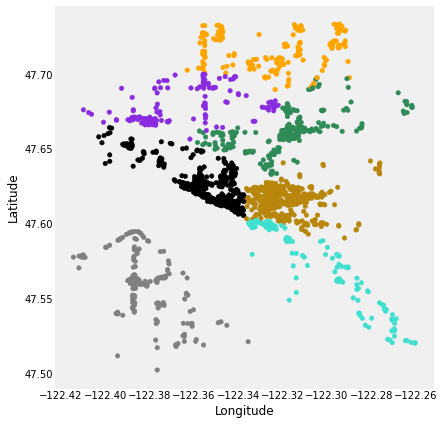

In [25]:
colors = ["grey", "turquoise", "darkgoldenrod", "seagreen", "orange", "blueviolet", "black"]
color_list = [colors[int(i-1)] for i in seattle.loc[:, "CouncilDistrictCode"]]

ax = seattle.plot.scatter(x="Longitude", y="Latitude", c=color_list, figsize=(6,7))
plt.grid(which="both", axis="both")
plt.show()

Now, we will create new features from either the original dataset or external sources to enhance the overall correlation between the feature set and the target.

# 1) Energy Use Type

Determine the energy use type of a building comparing different end uses

In [26]:
electricity_index = seattle.index[seattle["NaturalGas (kbtu)"]==0].tolist()
gas_index = seattle.index[seattle["Electricity (kbtu)"]==0].tolist()
mixed = seattle.index[(seattle["Electricity (kbtu)"]!=0) & (seattle["NaturalGas (kbtu)"]!=0)].tolist()

In [27]:
for i in range(seattle.shape[0]):
    
    if i in mixed:
        ratio = seattle.loc[i, "Electricity (kbtu)"] / seattle.loc[i, "NaturalGas (kbtu)"]
        
        if ratio >= 1.7:
            seattle.loc[i, "Energy Use"] = "Electricity"
            
        elif (ratio > 0.7) & (ratio < 1.7):
            seattle.loc[i, "Energy Use"] = "Mixed"
            
        elif ratio <= 0.7:
            seattle.loc[i, "Energy Use"] = "Natural Gas"
            
    else:    
        if i in electricity_index:
            seattle.loc[i, "Energy Use"] = "Electricity"

        elif i in gas_index:
            seattle.loc[i, "Energy Use"] = "Natural Gas"

In [28]:
seattle["Energy Use"].value_counts()

Electricity    1256
Mixed           351
Natural Gas     214
Name: Energy Use, dtype: int64

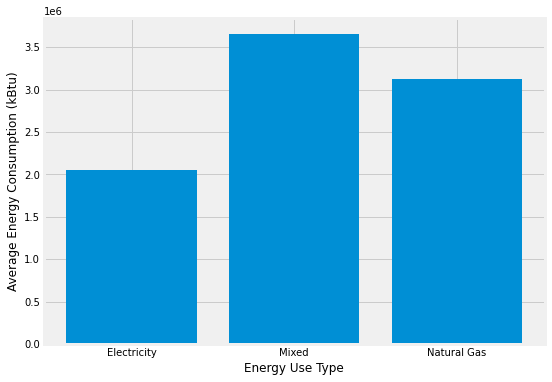

In [29]:
group = seattle.groupby(by="Energy Use")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(8, 6))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(rotation="horizontal")
plt.xlabel("Energy Use Type")
plt.ylabel("Average Energy Consumption (kBtu)")
plt.show()

In [30]:
seattle = seattle.drop(columns=["Electricity (kbtu)", "NaturalGas (kbtu)"])

In [31]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BuildingType              1821 non-null   object 
 1   Neighborhood              1821 non-null   object 
 2   CouncilDistrictCode       1821 non-null   float64
 3   Latitude                  1821 non-null   float64
 4   Longitude                 1821 non-null   float64
 5   YearBuilt                 1821 non-null   int64  
 6   NumberofFloors            1821 non-null   int64  
 7   PropertyGFABuilding(s)    1821 non-null   int64  
 8   Total Consumption (kbtu)  1821 non-null   float64
 9   Total EUI (kbtu/sf)       1821 non-null   float64
 10  Energy Use                1821 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 156.6+ KB


In [32]:
seattle.to_csv("seattle.csv", index=False)

# 2) CLIMATE

## 2.1) Landmarks

Now, assign landmarks using the latitude and longitude info

In [33]:
# COUNCIL 1
# Coastal Areas
c1_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.425) & (abs(seattle["Longitude"])>=122.336) & (seattle["Latitude"]>=47.576) & (seattle["Latitude"]<=47.597)].tolist()
c1_coastal2 = seattle.index[(abs(seattle["Longitude"])>=122.374) & (seattle["Latitude"]>=47.49) & (seattle["Latitude"]<=47.58)].tolist()
# Green Areas
c1_green1 = seattle.index[(abs(seattle["Longitude"])<=122.388) & (abs(seattle["Longitude"])>=122.383) & (seattle["Latitude"]>=47.591) & (seattle["Latitude"]<=47.595)].tolist()
c1_green2 = seattle.index[(abs(seattle["Longitude"])<=122.409) & (abs(seattle["Longitude"])>=122.396) & (seattle["Latitude"]>=47.571) & (seattle["Latitude"]<=47.5795)].tolist()
c1_green3 = seattle.index[(abs(seattle["Longitude"])<=122.387) & (abs(seattle["Longitude"])>=122.382) & (seattle["Latitude"]>=47.576) & (seattle["Latitude"]<=47.58)].tolist()
c1_green4 = seattle.index[(abs(seattle["Longitude"])<=122.377) & (abs(seattle["Longitude"])>=122.362) & (seattle["Latitude"]>=47.553) & (seattle["Latitude"]<=47.565)].tolist()
c1_green5 = seattle.index[(abs(seattle["Longitude"])<=122.346) & (abs(seattle["Longitude"])>=122.333) & (seattle["Latitude"]>=47.517) & (seattle["Latitude"]<=47.527)].tolist()
c1_green6 = seattle.index[(abs(seattle["Longitude"])<=122.372) & (abs(seattle["Longitude"])>=122.364) & (seattle["Latitude"]>=47.523) & (seattle["Latitude"]<=47.529)].tolist()
c1_green7 = seattle.index[(abs(seattle["Longitude"])<=122.388) & (abs(seattle["Longitude"])>=122.378) & (seattle["Latitude"]>=47.515) & (seattle["Latitude"]<=47.522)].tolist()
# Coastal and Green Areas
c1_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.362) & (abs(seattle["Longitude"])>=122.341) & (seattle["Latitude"]>=47.535) & (seattle["Latitude"]<=47.569)].tolist()

In [34]:
# COUNCIL 2
# Coastal Areas
c2_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.348) & (abs(seattle["Longitude"])>=122.334) & (seattle["Latitude"]>=47.55) & (seattle["Latitude"]<=47.605)].tolist()
c2_coastal2 = seattle.index[(abs(seattle["Longitude"])<=122.287) & (abs(seattle["Longitude"])>=122.233) & (seattle["Latitude"]>=47.508) & (seattle["Latitude"]<=47.588)].tolist()
# Green Areas
c2_green1 = seattle.index[(abs(seattle["Longitude"])<=122.335) & (abs(seattle["Longitude"])>=122.328) & (seattle["Latitude"]>=47.59) & (seattle["Latitude"]<=47.597)].tolist()
c2_green2 = seattle.index[(abs(seattle["Longitude"])<=122.315) & (abs(seattle["Longitude"])>=122.295) & (seattle["Latitude"]>=47.558) & (seattle["Latitude"]<=47.572)].tolist()
c2_green3 = seattle.index[(abs(seattle["Longitude"])<=122.289) & (abs(seattle["Longitude"])>=122.274) & (seattle["Latitude"]>=47.56) & (seattle["Latitude"]<=47.565)].tolist()
c2_green4 = seattle.index[(abs(seattle["Longitude"])<=122.321) & (abs(seattle["Longitude"])>=122.316) & (seattle["Latitude"]>=47.557) & (seattle["Latitude"]<=47.562)].tolist()
c2_green5 = seattle.index[(abs(seattle["Longitude"])<=122.297) & (abs(seattle["Longitude"])>=122.288) & (seattle["Latitude"]>=47.538) & (seattle["Latitude"]<=47.541)].tolist()
c2_green6 = seattle.index[(abs(seattle["Longitude"])<=122.262) & (abs(seattle["Longitude"])>=122.258) & (seattle["Latitude"]>=47.513) & (seattle["Latitude"]<=47.516)].tolist()
c2_green7 = seattle.index[(abs(seattle["Longitude"])<=122.284) & (abs(seattle["Longitude"])>=122.278) & (seattle["Latitude"]>=47.546) & (seattle["Latitude"]<=47.55)].tolist()
# Coastal and Green Areas
c2_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.266) & (abs(seattle["Longitude"])>=122.26) & (seattle["Latitude"]>=47.521) & (seattle["Latitude"]<=47.531)].tolist()

In [35]:
# COUNCIL 3
# Coastal Areas
c3_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.28) & (seattle["CouncilDistrictCode"]==3)].tolist()
c3_coastal2 = seattle.index[(abs(seattle["Longitude"])<=122.3298) & (abs(seattle["Longitude"])>=122.2784) & (seattle["Latitude"]>=47.6421) & (seattle["CouncilDistrictCode"]==3)].tolist()
c3_coastal3 = seattle.index[(abs(seattle["Longitude"])>=122.327) & (seattle["Latitude"]>=47.6259) & (seattle["CouncilDistrictCode"]==3)].tolist()
# Green Areas
c3_green1 = seattle.index[(abs(seattle["Longitude"])<=122.334) & (abs(seattle["Longitude"])>=122.33) & (seattle["Latitude"]>=47.59) & (seattle["Latitude"]<=47.597)].tolist()
c3_green2 = seattle.index[(abs(seattle["Longitude"])<=122.298) & (abs(seattle["Longitude"])>=122.285) & (seattle["Latitude"]>=47.62) & (seattle["Latitude"]<=47.64)].tolist()
c3_green3 = seattle.index[(abs(seattle["Longitude"])<=122.318) & (abs(seattle["Longitude"])>=122.312) & (seattle["Latitude"]>=47.628) & (seattle["Latitude"]<=47.636)].tolist()
c3_green4 = seattle.index[(abs(seattle["Longitude"])<=122.309) & (abs(seattle["Longitude"])>=122.303) & (seattle["Latitude"]>=47.6324) & (seattle["Latitude"]<=47.637)].tolist()
# Coastal and Green Areas
c3_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.314) & (abs(seattle["Longitude"])>=122.3063) & (seattle["Latitude"]>=47.64) & (seattle["Latitude"]<=47.6435)].tolist()
c3_coastal_green2 = seattle.index[(abs(seattle["Longitude"])<=122.297) & (abs(seattle["Longitude"])>=122.285) & (seattle["Latitude"]>=47.64) & (seattle["Latitude"]<=47.6469)].tolist()

In [36]:
# COUNCIL 4
# Coastal Areas
c4_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.348) & (abs(seattle["Longitude"])>=122.244) & (seattle["Latitude"]>=47.6445) & (seattle["Latitude"]<=47.6568) & (seattle["CouncilDistrictCode"]==4)].tolist()
c4_coastal2 = seattle.index[(abs(seattle["Longitude"])<=122.275) & (seattle["Latitude"]>=47.6481) & (seattle["Latitude"]<=47.706)].tolist()
# Green Areas
c4_green1 = seattle.index[(abs(seattle["Longitude"])<=122.3143) & (abs(seattle["Longitude"])>=122.30) & (seattle["Latitude"]>=47.668) & (seattle["Latitude"]<=47.674)].tolist()
c4_green2 = seattle.index[(abs(seattle["Longitude"])<=122.28) & (abs(seattle["Longitude"])>=122.265) & (seattle["Latitude"]>=47.683) & (seattle["Latitude"]<=47.691)].tolist()
c4_green3 = seattle.index[(abs(seattle["Longitude"])<=122.32) & (abs(seattle["Longitude"])>=122.31) & (seattle["Latitude"]>=47.68) & (seattle["Latitude"]<=47.70)].tolist()
# Coastal and Green Areas
c4_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.355) & (abs(seattle["Longitude"])>=122.325) & (seattle["Latitude"]>=47.665) & (seattle["Latitude"]<=47.686)].tolist()
c4_coastal_green2 = seattle.index[(abs(seattle["Longitude"])<=122.263) & (abs(seattle["Longitude"])>=122.245) & (seattle["Latitude"]>=47.673) & (seattle["Latitude"]<=47.686)].tolist()

In [37]:
# COUNCIL 5
# Coastal Areas
c5_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.282) & (seattle["Latitude"]>=47.682)].tolist()
c5_coastal2 = seattle.index[(abs(seattle["Longitude"])>=122.374) & (seattle["Latitude"]>=47.682)].tolist()
# Green Areas
c5_green1 = seattle.index[(abs(seattle["Longitude"])<=122.324) & (abs(seattle["Longitude"])>=122.312) & (seattle["Latitude"]>=47.723) & (seattle["Latitude"]<=47.735)].tolist()
c5_green2 = seattle.index[(abs(seattle["Longitude"])<=122.34) & (abs(seattle["Longitude"])>=122.33) & (seattle["Latitude"]>=47.72) & (seattle["Latitude"]<=47.726)].tolist()
c5_green3 = seattle.index[(abs(seattle["Longitude"])<=122.35) & (abs(seattle["Longitude"])>=122.33) & (seattle["Latitude"]>=47.708) & (seattle["Latitude"]<=47.72)].tolist()
c5_green4 = seattle.index[(abs(seattle["Longitude"])<=122.381) & (abs(seattle["Longitude"])>=122.376) & (seattle["Latitude"]>=47.69) & (seattle["Latitude"]<=47.70)].tolist()
c5_green5 = seattle.index[(abs(seattle["Longitude"])<=122.30) & (abs(seattle["Longitude"])>=122.29) & (seattle["Latitude"]>=47.70) & (seattle["Latitude"]<=47.71)].tolist()
# Coastal and Green Areas
c5_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.356) & (abs(seattle["Longitude"])>=122.348) & (seattle["Latitude"]>=47.723) & (seattle["Latitude"]<=47.73)].tolist()
c5_coastal_green2 = seattle.index[(abs(seattle["Longitude"])<=122.382) & (abs(seattle["Longitude"])>=122.36) & (seattle["Latitude"]>=47.7) & (seattle["Latitude"]<=47.72)].tolist()

In [38]:
# COUNCIL 6
# Coastal Areas
c6_coastal1 = seattle.index[(abs(seattle["Longitude"])>=122.397) & (seattle["Latitude"]>=47.667) & (seattle["Latitude"]<=47.705)].tolist()
c6_coastal2 = seattle.index[(abs(seattle["Longitude"])<=122.41) & (abs(seattle["Longitude"])>=122.33) & (seattle["Latitude"]>=47.644) & (seattle["Latitude"]<=47.672)].tolist()
# Green Areas
c6_green1 = seattle.index[(abs(seattle["Longitude"])<=122.355) & (abs(seattle["Longitude"])>=122.34) & (seattle["Latitude"]>=47.663) & (seattle["Latitude"]<=47.672)].tolist()
c6_green2 = seattle.index[(abs(seattle["Longitude"])<=122.382) & (abs(seattle["Longitude"])>=122.376) & (seattle["Latitude"]>=47.694) & (seattle["Latitude"]<=47.698)].tolist()
c6_green3 = seattle.index[(abs(seattle["Longitude"])<=122.385) & (abs(seattle["Longitude"])>=122.381) & (seattle["Latitude"]>=47.683) & (seattle["Latitude"]<=47.69)].tolist()
c6_green4 = seattle.index[(abs(seattle["Longitude"])<=122.385) & (abs(seattle["Longitude"])>=122.38) & (seattle["Latitude"]>=47.676) & (seattle["Latitude"]<=47.68)].tolist()
c6_green5 = seattle.index[(abs(seattle["Longitude"])<=122.372) & (abs(seattle["Longitude"])>=122.366) & (seattle["Latitude"]>=47.664) & (seattle["Latitude"]<=47.669)].tolist()
# Coastal and Green Areas
c6_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.339) & (abs(seattle["Longitude"])>=122.331) & (seattle["Latitude"]>=47.643) & (seattle["Latitude"]<=47.648)].tolist()
c6_coastal_green2 = seattle.index[(abs(seattle["Longitude"])<=122.348) & (abs(seattle["Longitude"])>=122.324) & (seattle["Latitude"]>=47.67) & (seattle["Latitude"]<=47.686)].tolist()
c6_coastal_green3 = seattle.index[(abs(seattle["Longitude"])<=122.339) & (abs(seattle["Longitude"])>=122.331) & (seattle["Latitude"]>=47.643) & (seattle["Latitude"]<=47.648)].tolist()

In [39]:
# COUNCIL 7
# Coastal Areas
c7_coastal1 = seattle.index[(abs(seattle["Longitude"])<=122.438) & (abs(seattle["Longitude"])>=122.341) & (seattle["Latitude"]>=47.643) & (seattle["Latitude"]<=47.673)].tolist()
c7_coastal2 = seattle.index[(abs(seattle["Longitude"])<=122.35) & (seattle["Latitude"]>=47.6245) & (seattle["Latitude"]<=47.646)].tolist()
c7_coastal3 = seattle.index[(abs(seattle["Longitude"])<=122.42) & (abs(seattle["Longitude"])>=122.37) & (seattle["Latitude"]>=47.624) & (seattle["Latitude"]<=47.64)].tolist()
c7_coastal4 = seattle.index[(abs(seattle["Longitude"])<=122.358) & (abs(seattle["Longitude"])>=122.338) & (seattle["Latitude"]>=47.558) & (seattle["Latitude"]<=47.618)].tolist()
c7_coastal5 = seattle.index[(abs(seattle["Longitude"])<=122.384) & (abs(seattle["Longitude"])>=122.354) & (seattle["Latitude"]>=47.61) & (seattle["Latitude"]<=47.64)].tolist()
# Green Areas
c7_green1 = seattle.index[(abs(seattle["Longitude"])<=122.381) & (abs(seattle["Longitude"])>=122.375) & (seattle["Latitude"]>=47.64) & (seattle["Latitude"]<=47.649)].tolist()
c7_green2 = seattle.index[(abs(seattle["Longitude"])<=122.393) & (abs(seattle["Longitude"])>=122.387) & (seattle["Latitude"]>=47.653) & (seattle["Latitude"]<=47.657)].tolist()
c7_green3 = seattle.index[(abs(seattle["Longitude"])<=122.394) & (abs(seattle["Longitude"])>=122.388) & (seattle["Latitude"]>=47.65) & (seattle["Latitude"]<=47.653)].tolist()
c7_green4 = seattle.index[(abs(seattle["Longitude"])<=122.402) & (abs(seattle["Longitude"])>=122.398) & (seattle["Latitude"]>=47.64) & (seattle["Latitude"]<=47.647)].tolist()
c7_green5 = seattle.index[(abs(seattle["Longitude"])<=122.381) & (abs(seattle["Longitude"])>=122.375) & (seattle["Latitude"]>=47.639) & (seattle["Latitude"]<=47.649)].tolist()
c7_green6 = seattle.index[(abs(seattle["Longitude"])<=122.369) & (abs(seattle["Longitude"])>=122.357) & (seattle["Latitude"]>=47.641) & (seattle["Latitude"]<=47.647)].tolist()
c7_green7 = seattle.index[(abs(seattle["Longitude"])<=122.348) & (abs(seattle["Longitude"])>=122.343) & (seattle["Latitude"]>=47.632) & (seattle["Latitude"]<=47.638)].tolist()
c7_green8 = seattle.index[(abs(seattle["Longitude"])<=122.377) & (abs(seattle["Longitude"])>=122.364) & (seattle["Latitude"]>=47.625) & (seattle["Latitude"]<=47.637)].tolist()
c7_green9 = seattle.index[(abs(seattle["Longitude"])<=122.388) & (abs(seattle["Longitude"])>=122.384) & (seattle["Latitude"]>=47.641) & (seattle["Latitude"]<=47.645)].tolist()
# Coastal and Green Areas
c7_coastal_green1 = seattle.index[(abs(seattle["Longitude"])<=122.443) & (abs(seattle["Longitude"])>=122.40) & (seattle["Latitude"]>=47.652) & (seattle["Latitude"]<=47.672)].tolist()
c7_coastal_green2 = seattle.index[(abs(seattle["Longitude"])<=122.341) & (abs(seattle["Longitude"])>=122.333) & (seattle["Latitude"]>=47.625) & (seattle["Latitude"]<=47.629)].tolist()
c7_coastal_green3 = seattle.index[(abs(seattle["Longitude"])<=122.403) & (abs(seattle["Longitude"])>=122.396) & (seattle["Latitude"]>=47.663) & (seattle["Latitude"]<=47.667)].tolist()
c7_coastal_green4 = seattle.index[(abs(seattle["Longitude"])<=122.364) & (abs(seattle["Longitude"])>=122.35) & (seattle["Latitude"]>=47.613) & (seattle["Latitude"]<=47.617)].tolist()


In [40]:
# COASTAL AREAS
coastals = c1_coastal1 + c1_coastal2 + c2_coastal1 + c2_coastal2 + c3_coastal1 + c3_coastal2 + c3_coastal3 + c4_coastal1 + c4_coastal2 + c5_coastal1 + c5_coastal2 + c6_coastal1 + c6_coastal2 + c7_coastal1 + c7_coastal2 + c7_coastal3 + c7_coastal4 + c7_coastal5
coastal_areas = set(coastals)
greens = c1_green1 + c1_green2 + c1_green3 + c1_green4 + c1_green5 + c1_green6 + c1_green7 + c2_green1 + c2_green2 + c2_green3 + c2_green4 + c2_green5 + c2_green6 + c2_green7 + c3_green1 + c3_green2 + c3_green3 + c3_green4 + c4_green1 + c4_green2 + c4_green3 + c5_green1 + c5_green2 + c5_green3 + c5_green4 + c5_green5 + c6_green1 + c6_green2 + c6_green3 + c6_green4 + c6_green5 + c7_green1 + c7_green2 + c7_green3 + c7_green4 + c7_green5 + c7_green6 + c7_green7 + c7_green8 + c7_green9                           
green_areas = set(greens)
mixed = c1_coastal_green1 + c2_coastal_green1 + c3_coastal_green1 + c3_coastal_green2 + c4_coastal_green1 + c4_coastal_green2 + c5_coastal_green1 + c5_coastal_green2 + c6_coastal_green1 + c6_coastal_green2 + c6_coastal_green3 + c7_coastal_green1 + c7_coastal_green2 + c7_coastal_green3 + c7_coastal_green4
coastal_green = set(mixed)

In [41]:
print("Coastal Areas:", len(coastal_areas))
print("Green Areas:", len(green_areas))
print("Coastal and Green Areas:", len(coastal_green))

Coastal Areas: 793
Green Areas: 131
Coastal and Green Areas: 72


In [42]:
for i in coastal_green:
    
    if i in green_areas:
        green_areas.remove(i)
        
    elif i in coastal_areas:
        coastal_areas.remove(i)
        
for j in green_areas:
    
    if j in coastal_areas:
        coastal_areas.remove(j)

In [43]:
print("Coastal Areas:", len(coastal_areas))
print("Green Areas:", len(green_areas))
print("Coastal and Green Areas:", len(coastal_green))

Coastal Areas: 679
Green Areas: 129
Coastal and Green Areas: 72


Assing landmark labels to the instances. Three classes: (1) Terrain, (2) Green Area, (3) Coastal Area.

In [44]:
for i in range(seattle.shape[0]):
    
    if i in coastal_green:
        seattle.loc[i, "Landmark"] = "Coastal and Green"
        
    elif i in green_areas:
        seattle.loc[i, "Landmark"] = "Green"
        
    elif i in coastal_areas:
        seattle.loc[i, "Landmark"] = "Coastal"
        
    else:
        seattle.loc[i, "Landmark"] = "Terrain"

In [45]:
seattle["Landmark"].value_counts()

Terrain              943
Coastal              677
Green                129
Coastal and Green     72
Name: Landmark, dtype: int64

In [46]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BuildingType              1821 non-null   object 
 1   Neighborhood              1821 non-null   object 
 2   CouncilDistrictCode       1821 non-null   float64
 3   Latitude                  1821 non-null   float64
 4   Longitude                 1821 non-null   float64
 5   YearBuilt                 1821 non-null   int64  
 6   NumberofFloors            1821 non-null   int64  
 7   PropertyGFABuilding(s)    1821 non-null   int64  
 8   Total Consumption (kbtu)  1821 non-null   float64
 9   Total EUI (kbtu/sf)       1821 non-null   float64
 10  Energy Use                1821 non-null   object 
 11  Landmark                  1821 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 170.8+ KB


In [47]:
seattle.groupby(by="Landmark")["Total Consumption (kbtu)"].mean()

Landmark
Coastal              2.655979e+06
Coastal and Green    3.007086e+06
Green                1.407130e+06
Terrain              2.470037e+06
Name: Total Consumption (kbtu), dtype: float64

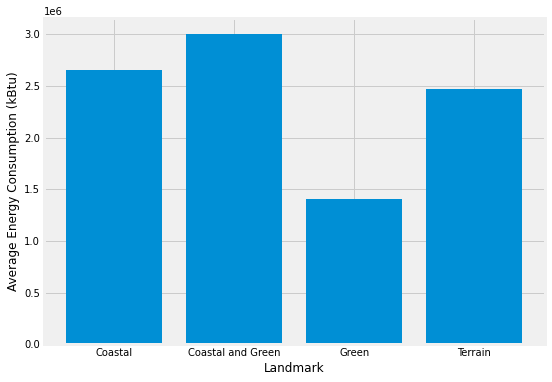

In [48]:
group = seattle.groupby(by="Landmark")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(8, 6))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(rotation="horizontal")
plt.xlabel("Landmark")
plt.ylabel("Average Energy Consumption (kBtu)")
plt.show()

Reduce the cardinality. Use only three category for the landmark labels. For this, transform the "Coastal and Green" zones into "Coastal" zones:

In [49]:
seattle["Landmark"].value_counts()

Terrain              943
Coastal              677
Green                129
Coastal and Green     72
Name: Landmark, dtype: int64

In [50]:
for i in range(seattle.shape[0]):
    
    if seattle.loc[i, "Landmark"] == "Coastal and Green":
        seattle.loc[i, "Landmark"] = "Coastal"
        
seattle["Landmark"].value_counts()

Terrain    943
Coastal    749
Green      129
Name: Landmark, dtype: int64

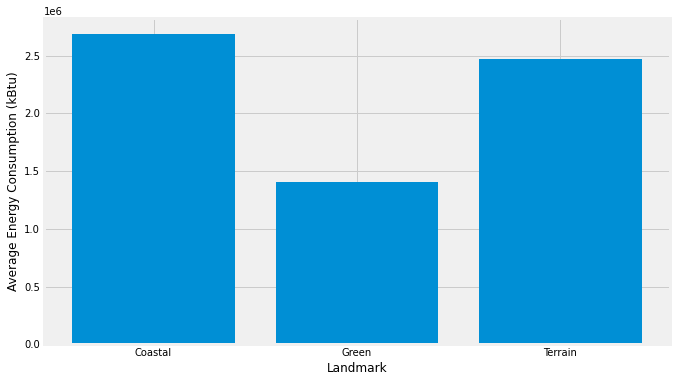

In [51]:
group = seattle.groupby(by="Landmark")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(10, 6))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(rotation="horizontal")
plt.xlabel("Landmark")
plt.ylabel("Average Energy Consumption (kBtu)")
plt.show()

Save the **seattle** as a csv file:

In [52]:
seattle.to_csv("seattle.csv", index=False)

In [53]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BuildingType              1821 non-null   object 
 1   Neighborhood              1821 non-null   object 
 2   CouncilDistrictCode       1821 non-null   float64
 3   Latitude                  1821 non-null   float64
 4   Longitude                 1821 non-null   float64
 5   YearBuilt                 1821 non-null   int64  
 6   NumberofFloors            1821 non-null   int64  
 7   PropertyGFABuilding(s)    1821 non-null   int64  
 8   Total Consumption (kbtu)  1821 non-null   float64
 9   Total EUI (kbtu/sf)       1821 non-null   float64
 10  Energy Use                1821 non-null   object 
 11  Landmark                  1821 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 170.8+ KB


## 2.2) Weather Data

Link: https://www.windfinder.com/windstatistics/broadview_seattle

In [54]:
mydf = pd.read_csv("seattle.csv")

In [55]:
seattle = mydf.copy()

In [56]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BuildingType              1821 non-null   object 
 1   Neighborhood              1821 non-null   object 
 2   CouncilDistrictCode       1821 non-null   float64
 3   Latitude                  1821 non-null   float64
 4   Longitude                 1821 non-null   float64
 5   YearBuilt                 1821 non-null   int64  
 6   NumberofFloors            1821 non-null   int64  
 7   PropertyGFABuilding(s)    1821 non-null   int64  
 8   Total Consumption (kbtu)  1821 non-null   float64
 9   Total EUI (kbtu/sf)       1821 non-null   float64
 10  Energy Use                1821 non-null   object 
 11  Landmark                  1821 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 170.8+ KB


In [57]:
seattle["Neighborhood"].value_counts()

EAST                      357
MAGNOLIA / QUEEN ANNE     279
DOWNTOWN                  229
NORTHEAST                 169
NORTHWEST                 137
SOUTHWEST                 131
LAKE UNION                119
NORTH                     118
CENTRAL                    87
BALLARD                    75
SOUTHEAST                  50
DELRIDGE NEIGHBORHOODS     39
GREATER DUWAMISH           31
Name: Neighborhood, dtype: int64

Try to determine the annual weather recordings, such as wind speed and air temperature, using the weather stations near to the specific neighborhoods:

In [58]:
ei = seattle.index[seattle["Neighborhood"]=="EAST"].tolist()
magnolia_index = seattle.index[seattle["Neighborhood"]=="MAGNOLIA / QUEEN ANNE"].tolist()
downtown_index = east_index = seattle.index[(seattle["Neighborhood"]=="DOWNTOWN")].tolist()
ne_index = seattle.index[(seattle["Neighborhood"]=="NORTHEAST")].tolist()
nw_index = seattle.index[(seattle["Neighborhood"]=="NORTHWEST")].tolist()
sw_index = seattle.index[(seattle["Neighborhood"]=="SOUTHWEST")].tolist()
lake_index = seattle.index[(seattle["Neighborhood"]=="LAKE UNION")].tolist()
north_index = seattle.index[(seattle["Neighborhood"]=="NORTH")].tolist()
central_index = seattle.index[(seattle["Neighborhood"]=="CENTRAL")].tolist()
ballard_index = seattle.index[(seattle["Neighborhood"]=="BALLARD")].tolist()
se_index = seattle.index[(seattle["Neighborhood"]=="SOUTHEAST")].tolist()
delridge_index = seattle.index[(seattle["Neighborhood"]=="DELRIDGE NEIGHBORHOODS")].tolist()
duwamish_index = seattle.index[(seattle["Neighborhood"]=="GREATER DUWAMISH")].tolist()

In [59]:
for i in range(seattle.shape[0]):
    
    if i in ei:
        seattle.loc[i, "Wind Speed (kts)"] = 3
        seattle.loc[i, "Daytime Temperature (C)"] = 13
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    elif i in magnolia_index:
        seattle.loc[i, "Wind Speed (kts)"] = 3
        seattle.loc[i, "Daytime Temperature (C)"] = 12
        seattle.loc[i, "Nighttime Temperature (C)"] = 10
        
    elif i in downtown_index:
        seattle.loc[i, "Wind Speed (kts)"] = 5
        seattle.loc[i, "Daytime Temperature (C)"] = 12
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    elif i in ne_index:
        seattle.loc[i, "Wind Speed (kts)"] = 3.7
        seattle.loc[i, "Daytime Temperature (C)"] = 12.3
        seattle.loc[i, "Nighttime Temperature (C)"] = 10.7
        
    elif i in nw_index:
        seattle.loc[i, "Wind Speed (kts)"] = 2
        seattle.loc[i, "Daytime Temperature (C)"] = 12
        seattle.loc[i, "Nighttime Temperature (C)"] = 10
        
    elif i in sw_index:
        if seattle.loc[i, "Landmark"] == "Coastal":
            seattle.loc[i, "Wind Speed (kts)"] = 6
            seattle.loc[i, "Daytime Temperature (C)"] = 12
            seattle.loc[i, "Nighttime Temperature (C)"] = 11
        else:
            seattle.loc[i, "Wind Speed (kts)"] = 3.7
            seattle.loc[i, "Daytime Temperature (C)"] = 12.7
            seattle.loc[i, "Nighttime Temperature (C)"] = 10
            
    elif i in lake_index:
        seattle.loc[i, "Wind Speed (kts)"] = 3
        seattle.loc[i, "Daytime Temperature (C)"] = 14
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    
    elif i in north_index:
        seattle.loc[i, "Wind Speed (kts)"] = 5
        seattle.loc[i, "Daytime Temperature (C)"] = 13
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    elif i in central_index:
        seattle.loc[i, "Wind Speed (kts)"] = 4
        seattle.loc[i, "Daytime Temperature (C)"] = 12.5
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    elif i in ballard_index:
        seattle.loc[i, "Wind Speed (kts)"] = 3
        seattle.loc[i, "Daytime Temperature (C)"] = 13
        seattle.loc[i, "Nighttime Temperature (C)"] = 10
        
    elif i in se_index:
        seattle.loc[i, "Wind Speed (kts)"] = 1
        seattle.loc[i, "Daytime Temperature (C)"] = 14
        seattle.loc[i, "Nighttime Temperature (C)"] = 11
        
    elif i in delridge_index:
        seattle.loc[i, "Wind Speed (kts)"] = 5
        seattle.loc[i, "Daytime Temperature (C)"] = 13
        seattle.loc[i, "Nighttime Temperature (C)"] = 10
        
    elif i in duwamish_index:
        seattle.loc[i, "Wind Speed (kts)"] = 5
        seattle.loc[i, "Daytime Temperature (C)"] = 13
        seattle.loc[i, "Nighttime Temperature (C)"] = 10   
        
    else:
        print("ERROR", i)

In [60]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

In [61]:
seattle.to_csv("seattle.csv", index=False)

## Creating Climate Classes

In [62]:
mydf = pd.read_csv("seattle.csv")

In [63]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

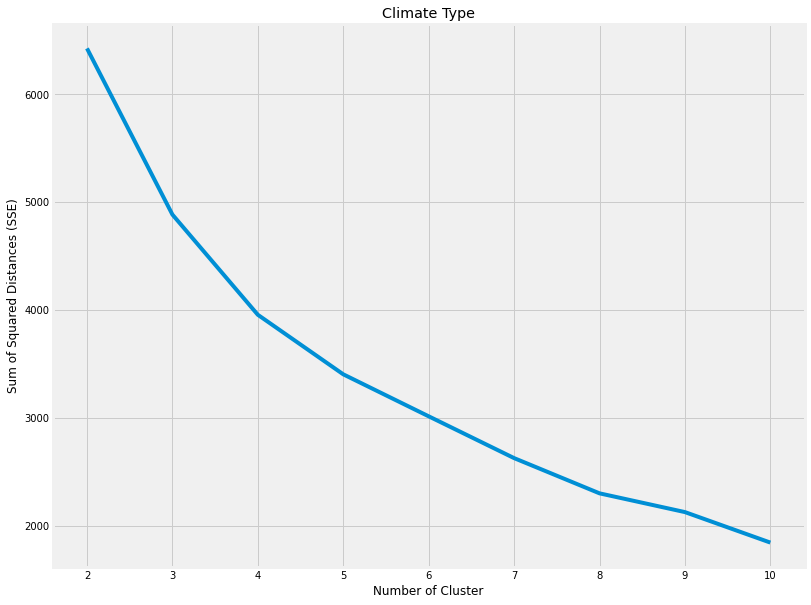

In [64]:
from sklearn.cluster import KMeans

cluster_features = [
    'Neighborhood',
    'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    'Energy Use',
    'Landmark',
    'Wind Speed (kts)',
    'Daytime Temperature (C)',
    'Nighttime Temperature (C)',
]

cluster_df = mydf.loc[:, cluster_features]
data = pd.get_dummies(cluster_df)
data_train, data_test = train_test_split(
    data, test_size=0.20,
    stratify=cluster_df["Neighborhood"],
    shuffle=True, random_state=42,
)

sse = list()

min_cluster = 2
max_cluster = 11

for k in range(min_cluster, max_cluster):
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42,
    )
    kmeans.fit(data_train)
    sse.append(kmeans.inertia_)
    
# Visualize results
plt.figure(figsize=(12, 10))
plt.plot(range(min_cluster, max_cluster), sse)
plt.xlabel("Number of Cluster")
plt.ylabel("Sum of Squared Distances (SSE)")
plt.xticks(range(min_cluster, max_cluster))
plt.title("Climate Type")
plt.show()

In [65]:
from kneed import KneeLocator
kl = KneeLocator(range(min_cluster, max_cluster), sse, curve="convex", direction="decreasing")
best_cluster = kl.elbow
print("Optimal cluster number:", best_cluster)

Optimal cluster number: 4


In [66]:
k_means = KMeans(
    n_clusters=best_cluster,
    random_state=42,
)

k_means.fit(data_train)
labels = k_means.predict(data)

unique, counts = np.unique(labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 506]
 [  1 767]
 [  2 286]
 [  3 262]]


In [67]:
mydf.loc[:, "Climate Type"] = labels

In [68]:
mydf.corr()["Total Consumption (kbtu)"]

CouncilDistrictCode          0.087786
Latitude                    -0.076924
Longitude                    0.029863
YearBuilt                    0.173866
NumberofFloors               0.707402
PropertyGFABuilding(s)       0.884253
Total Consumption (kbtu)     1.000000
Total EUI (kbtu/sf)          0.371233
Wind Speed (kts)             0.099616
Daytime Temperature (C)     -0.032184
Nighttime Temperature (C)    0.130781
Climate Type                 0.180875
Name: Total Consumption (kbtu), dtype: float64

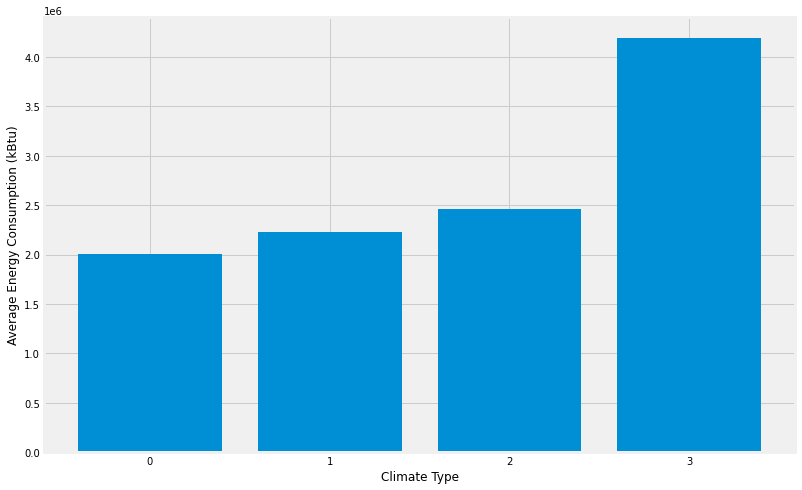

In [69]:
group = mydf.groupby(by="Climate Type")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(12, 8))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(np.arange(0, 4), rotation="horizontal")
plt.xlabel("Climate Type")
plt.ylabel("Average Energy Consumption (kBtu)")
plt.show()

In [70]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

In [71]:
mydf.to_csv("seattle.csv", index=False)

# 3) Energy Efficiency Classes

To determine the energy efficiency classes, we will use the following features: **Energy Use, Earthquake Risk, Flood Risk, Water Bodies, Commercial, Industrial, and Public Utilities.** 

## 3.1) Earthquake Risk

Links: 1) https://www.soundseismic.com/earthquake-resources/hazard-maps

In [72]:
mydf = pd.read_csv("seattle.csv")

In [73]:
seattle = mydf.copy()

In [74]:
for i in range(seattle.shape[0]):
    
    if seattle.loc[i, "Neighborhood"] == "DOWNTOWN":
        if seattle.loc[i, "CouncilDistrictCode"] == 2:
            seattle.loc[i, "Earthquake Risk"] = "High"
        else:
            seattle.loc[i, "Earthquake Risk"] = "Fair"
            
    elif seattle.loc[i, "Neighborhood"] == "EAST":
        seattle.loc[i, "Earthquake Risk"] = "Fair"
            
    elif seattle.loc[i, "Neighborhood"] == "MAGNOLIA / QUEEN ANNE":
        seattle.loc[i, "Earthquake Risk"] = "Moderate"
        
    elif seattle.loc[i, "Neighborhood"] == "GREATER DUWAMISH":
        seattle.loc[i, "Earthquake Risk"] = "High"
        
    elif seattle.loc[i, "Neighborhood"] == "NORTHEAST":
        seattle.loc[i, "Earthquake Risk"] = "Fair"
        
    elif seattle.loc[i, "Neighborhood"] == "LAKE UNION":
        if seattle.loc[i, "CouncilDistrictCode"] == 7:
            seattle.loc[i, "Earthquake Risk"] = "Moderate"
        else:
            seattle.loc[i, "Earthquake Risk"] = "Fair"
            
    elif seattle.loc[i, "Neighborhood"] == "NORTHWEST":
        if seattle.loc[i, "CouncilDistrictCode"] == 5:
            seattle.loc[i, "Earthquake Risk"] = "Lower"
        else:
            seattle.loc[i, "Earthquake Risk"] = "Fair"
            
    elif seattle.loc[i, "Neighborhood"] == "NORTH":
        seattle.loc[i, "Earthquake Risk"] = "Lower"
        
    elif seattle.loc[i, "Neighborhood"] == "SOUTHWEST":
        seattle.loc[i, "Earthquake Risk"] = "Low"
        
    elif seattle.loc[i, "Neighborhood"] == "BALLARD":
        if seattle.loc[i, "Landmark"] == "Coastal":
            seattle.loc[i, "Earthquake Risk"] = "Moderate"
        else:
            seattle.loc[i, "Earthquake Risk"] = "Fair"
            
    elif seattle.loc[i, "Neighborhood"] == "CENTRAL":
        seattle.loc[i, "Earthquake Risk"] = "Fair"
        
    elif seattle.loc[i, "Neighborhood"] == "SOUTHEAST":
        seattle.loc[i, "Earthquake Risk"] = "Low"
        
    elif seattle.loc[i, "Neighborhood"] == "DELRIDGE NEIGHBORHOODS":
        seattle.loc[i, "Earthquake Risk"] = "Moderate"

In [75]:
seattle["Earthquake Risk"].value_counts()

Fair        970
Moderate    392
Lower       189
Low         181
High         89
Name: Earthquake Risk, dtype: int64

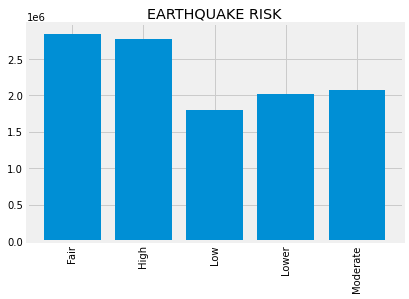

In [76]:
group = seattle.groupby(by="Earthquake Risk")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(6, 4))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(rotation="vertical")
plt.title("Earthquake Risk".upper())
plt.show()

In [77]:
seattle.to_csv("seattle.csv", index=False)

## 3.2) Flood Risk

1) https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::flood-zones-eca/about
2) nhttps://www.seattle.gov/emergency-management/hazards/floods

In [78]:
mydf = pd.read_csv("seattle.csv")

In [79]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

In [80]:
seattle = mydf.copy()

In [81]:
flood_prone_districts = [1, 6, 7]
flood_index = seattle.index[(seattle["Landmark"]=="Coastal") & ((seattle["CouncilDistrictCode"]==1) | (seattle["CouncilDistrictCode"]==6) | (seattle["CouncilDistrictCode"]==7))].tolist()

In [82]:
drainage_index = seattle.index[((seattle["CouncilDistrictCode"]==5) & ((seattle["Landmark"]=="Coastal") | (seattle["Landmark"]=="Coastal and Green"))) | (seattle["Neighborhood"]=="DELRIDGE NEIGHBORHOODS")].tolist()

The rest have no flood risk according to the map here: https://www.seattle.gov/emergency-management/hazards/floods 

Now, label the instances with (1) Flood, (2) Drainage Flood, (3) No Flood

In [83]:
for i in drainage_index:
    
    if i in flood_index:
        flood_index.remove(i)

In [84]:
for i in range(seattle.shape[0]):
    
    if i in flood_index:
        seattle.loc[i, "Flood Risk"] = "Flood"
        
    elif i in drainage_index:
        seattle.loc[i, "Flood Risk"] = "Drainage Flood"
        
    else:
        seattle.loc[i, "Flood Risk"] = "No Flood"

In [85]:
seattle["Flood Risk"].value_counts()

No Flood          1230
Flood              536
Drainage Flood      55
Name: Flood Risk, dtype: int64

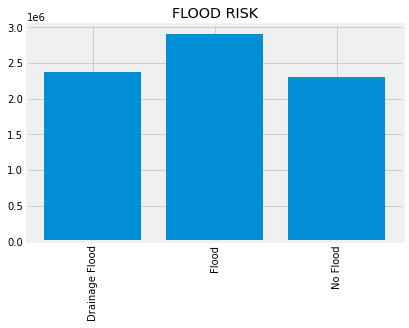

In [86]:
group = seattle.groupby(by="Flood Risk")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(6, 4))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(rotation="vertical")
plt.title("Flood Risk".upper())
plt.show()

In [87]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

In [88]:
seattle.to_csv("seattle.csv", index=False)

## 3.3) Demographics

In [89]:
mydf = pd.read_csv("seattle.csv")

In [90]:
seattle = mydf.copy()

In [91]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

Determine the number of total important facilities, such as industrial, public, and institiutional, from the neighborhood info. Also, insert the "Reservoirs/Water Bodies" info for each **CouncilDistrictCode**. Link: https://www.seattle.gov/opcd/population-and-demographics/about-seattle#landusezoningandpermitting

In [92]:
seattle["Neighborhood"].value_counts()

EAST                      357
MAGNOLIA / QUEEN ANNE     279
DOWNTOWN                  229
NORTHEAST                 169
NORTHWEST                 137
SOUTHWEST                 131
LAKE UNION                119
NORTH                     118
CENTRAL                    87
BALLARD                    75
SOUTHEAST                  50
DELRIDGE NEIGHBORHOODS     39
GREATER DUWAMISH           31
Name: Neighborhood, dtype: int64

In [93]:
water_bodies = [3, 0, 4, 20, 20, 256, 0]

for i in range(seattle.shape[0]):
    
    cd = np.int32(seattle.loc[i, "CouncilDistrictCode"])
    seattle.loc[i, "Water Bodies"] = water_bodies[cd-1]
    
    if seattle.loc[i, "Neighborhood"] == "EAST":
        seattle.loc[i, "Commercial"] = 126
        seattle.loc[i, "Industrial"] = 29
        seattle.loc[i, "Public Utilities"] = 130
        
    elif seattle.loc[i, "Neighborhood"] == "MAGNOLIA / QUEEN ANNE":
        seattle.loc[i, "Commercial"] = 234
        seattle.loc[i, "Industrial"] = 40
        seattle.loc[i, "Public Utilities"] = 141
        
    elif seattle.loc[i, "Neighborhood"] == "DOWNTOWN":
        seattle.loc[i, "Commercial"] = 168
        seattle.loc[i, "Industrial"] = 17
        seattle.loc[i, "Public Utilities"] = 67
        
    elif seattle.loc[i, "Neighborhood"] == "NORTHEAST":
        seattle.loc[i, "Commercial"] = 315
        seattle.loc[i, "Industrial"] = 46
        seattle.loc[i, "Public Utilities"] = 796
        
    elif seattle.loc[i, "Neighborhood"] == "NORTHWEST":
        seattle.loc[i, "Commercial"] = 302
        seattle.loc[i, "Industrial"] = 105
        seattle.loc[i, "Public Utilities"] = 178
        
        
    elif seattle.loc[i, "Neighborhood"] == "SOUTHWEST":
        seattle.loc[i, "Commercial"] = 199
        seattle.loc[i, "Industrial"] = 143
        seattle.loc[i, "Public Utilities"] = 362
        
    elif seattle.loc[i, "Neighborhood"] == "LAKE UNION":
        seattle.loc[i, "Commercial"] = 273
        seattle.loc[i, "Industrial"] = 58
        seattle.loc[i, "Public Utilities"] = 47
        
    elif seattle.loc[i, "Neighborhood"] == "NORTH":
        seattle.loc[i, "Commercial"] = 471
        seattle.loc[i, "Industrial"] = 81
        seattle.loc[i, "Public Utilities"] = 352
        
    elif seattle.loc[i, "Neighborhood"] == "CENTRAL":
        seattle.loc[i, "Commercial"] = 192
        seattle.loc[i, "Industrial"] = 46
        seattle.loc[i, "Public Utilities"] = 149
        
    elif seattle.loc[i, "Neighborhood"] == "BALLARD":
        seattle.loc[i, "Commercial"] = 92
        seattle.loc[i, "Industrial"] = 76
        seattle.loc[i, "Public Utilities"] = 20
        
    elif seattle.loc[i, "Neighborhood"] == "SOUTHEAST":
        seattle.loc[i, "Commercial"] = 473
        seattle.loc[i, "Industrial"] = 1043
        seattle.loc[i, "Public Utilities"] = 1321
        
    elif seattle.loc[i, "Neighborhood"] == "DELRIDGE NEIGHBORHOODS":
        seattle.loc[i, "Commercial"] = 27
        seattle.loc[i, "Industrial"] = 222
        seattle.loc[i, "Public Utilities"] = 437
        
    elif seattle.loc[i, "Neighborhood"] == "GREATER DUWAMISH":
        seattle.loc[i, "Commercial"] = 190
        seattle.loc[i, "Industrial"] = 570
        seattle.loc[i, "Public Utilities"] = 452
        
    else:
        print("ERROR")

Observe the correlation between features and target:

In [94]:
seattle.corr()["Total Consumption (kbtu)"]

CouncilDistrictCode          0.087786
Latitude                    -0.076924
Longitude                    0.029863
YearBuilt                    0.173866
NumberofFloors               0.707402
PropertyGFABuilding(s)       0.884253
Total Consumption (kbtu)     1.000000
Total EUI (kbtu/sf)          0.371233
Wind Speed (kts)             0.099616
Daytime Temperature (C)     -0.032184
Nighttime Temperature (C)    0.130781
Climate Type                 0.180875
Water Bodies                -0.042874
Commercial                  -0.098062
Industrial                  -0.038829
Public Utilities            -0.102065
Name: Total Consumption (kbtu), dtype: float64

Save the dataset

In [95]:
seattle.to_csv("seattle.csv", index=False)

## 3.4) Energy Efficiency Classes

We will know create a feature called **Energy Efficiency Class** using the above features (Energy Use, 3.1, 3.2, and 3.3)

In [96]:
mydf = pd.read_csv("seattle.csv")

In [97]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

Perform K-Means Clustering to determine the Energy Efficiency Classes

Try different cluster numbers to obtain the optimal number. We will use the Sum of squared distances of samples to their closest cluster center, called **SSE.**

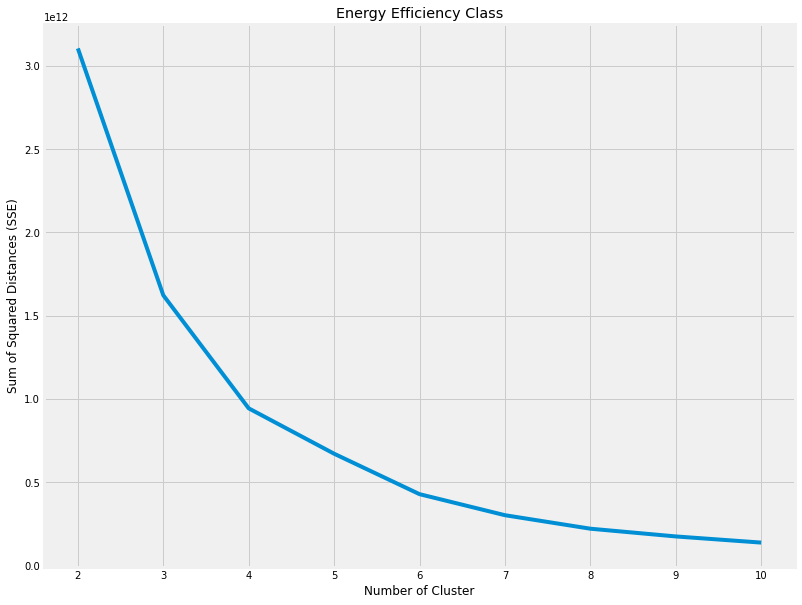

In [98]:
from sklearn.cluster import KMeans

cluster_features = [
    'BuildingType',
    'Neighborhood',
    'CouncilDistrictCode',
    'YearBuilt',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'Energy Use',
    'Climate Type',
    'Earthquake Risk',
    'Flood Risk',
    'Commercial',
    'Industrial',
    'Public Utilities',
]

cluster_df = mydf.loc[:, cluster_features]
data = pd.get_dummies(cluster_df)
data_train, data_test = train_test_split(
    data, test_size=0.20,
    stratify=cluster_df["Neighborhood"],
    shuffle=True, random_state=42,
)

sse = list()

min_cluster = 2
max_cluster = 11

for k in range(min_cluster, max_cluster):
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42,
    )
    kmeans.fit(data_train)
    sse.append(kmeans.inertia_)
    
# Visualize results
plt.figure(figsize=(12, 10))
plt.plot(range(min_cluster, max_cluster), sse)
plt.xlabel("Number of Cluster")
plt.ylabel("Sum of Squared Distances (SSE)")
plt.xticks(range(min_cluster, max_cluster))
plt.title("Energy Efficiency Class")
plt.show()

Find the optimal point using KneeLocator. The optimal point is the point where the error reduction slows down. After this point, increasing the cluster number does not improve the results.

In [99]:
from kneed import KneeLocator
kl = KneeLocator(range(min_cluster, max_cluster), sse, curve="convex", direction="decreasing")
best_cluster = kl.elbow
print("Optimal cluster number:", best_cluster)

Optimal cluster number: 4


Fit the clustering model using the optimal cluster number:

In [100]:
k_means = KMeans(
    n_clusters=best_cluster,
    random_state=42,
)

k_means.fit(data_train)
labels = k_means.predict(data)

unique, counts = np.unique(labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0  354]
 [   1 1347]
 [   2   27]
 [   3   93]]


In [101]:
mydf.loc[:, "Energy Efficiency Class"] = labels

Observe the correlation between features and target:

In [102]:
mydf.corr()["Total Consumption (kbtu)"]

CouncilDistrictCode          0.087786
Latitude                    -0.076924
Longitude                    0.029863
YearBuilt                    0.173866
NumberofFloors               0.707402
PropertyGFABuilding(s)       0.884253
Total Consumption (kbtu)     1.000000
Total EUI (kbtu/sf)          0.371233
Wind Speed (kts)             0.099616
Daytime Temperature (C)     -0.032184
Nighttime Temperature (C)    0.130781
Climate Type                 0.180875
Water Bodies                -0.042874
Commercial                  -0.098062
Industrial                  -0.038829
Public Utilities            -0.102065
Energy Efficiency Class      0.297826
Name: Total Consumption (kbtu), dtype: float64

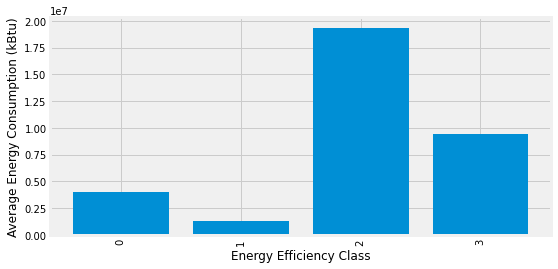

In [103]:
group = mydf.groupby(by="Energy Efficiency Class")["Total Consumption (kbtu)"].mean()

plt.figure(figsize=(8, 4))
plt.bar(x=group.index.tolist(), height=group.values)
plt.xticks(np.arange(0, 4), rotation="vertical")
plt.xlabel("Energy Efficiency Class")
plt.ylabel("Average Energy Consumption (kBtu)")
plt.show()

Finally, save the dataset

In [104]:
mydf.to_csv("ready_data.csv", index=False)

In [105]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   float64
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

# END